# **Notebook 5 : Évaluation du Modèle**

Dans ce notebook, nous évaluons les performances du modèle fusionné sur l'ensemble de test. Les étapes effectuées sont :

- **Chargement du Modèle Fusionné :** Nous chargeons le modèle fusionné entraîné précédemment.
- **Évaluation des Performances :** Nous calculons les métriques de performance telles que la perte (`loss`) et la précision binaire (`binary_accuracy`).
- **Visualisation des Courbes d'Apprentissage :** Nous traçons les courbes de la perte et de la précision au cours des époques d'entraînement.
- **Analyse des Résultats :** Nous interprétons les résultats pour comprendre les forces et les faiblesses du modèle.

**Pourquoi ?**

L'évaluation du modèle est essentielle pour mesurer sa capacité à généraliser sur des données inconnues. En analysant les métriques et les courbes d'apprentissage, nous pouvons identifier les problèmes potentiels comme le surapprentissage et prendre des décisions pour améliorer le modèle.


In [1]:
# Import des bibliothèques nécessaires
import os
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import pandas as pd


In [2]:
# Chemins des données et du modèle
data_dir = "../datasets/flickr8k/"
model_dir = "../models/"

# Charger les données de test
with open(os.path.join(data_dir, "test_data.pkl"), "rb") as f:
    test_data = pickle.load(f)

# Charger le tokenizer et les labels de classe
with open(os.path.join(data_dir, "tokenizer.pkl"), "rb") as f:
    tokenizer = pickle.load(f)

with open(os.path.join(data_dir, "class_labels.pkl"), "rb") as f:
    class_labels = pickle.load(f)

# Charger le modèle fusionné
multi_modal_model = load_model(os.path.join(model_dir, "multi_modal_model.keras"))

print("Modèle fusionné chargé avec succès.")


Modèle fusionné chargé avec succès.


In [3]:
# Paramètres globaux
IMG_SIZE = (224, 224)
MAX_SEQUENCE_LENGTH = 30  # Doit correspondre à la longueur utilisée précédemment
NUM_CLASSES = len(class_labels)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = preprocess_input(img)
    return img

# Préparer les ensembles de test
def prepare_data(data):
    images, sequences, labels = zip(*data)
    images = np.array([load_and_preprocess_image(img_path) for img_path in images])
    sequences = np.array(sequences)
    labels = np.array(labels)
    return images, sequences, labels

X_test_img, X_test_seq, y_test = prepare_data(test_data)

print(f"Dimensions des images de test : {X_test_img.shape}")
print(f"Dimensions des séquences de test : {X_test_seq.shape}")
print(f"Dimensions des étiquettes de test : {y_test.shape}")


Dimensions des images de test : (5000, 224, 224, 3)
Dimensions des séquences de test : (5000, 30)
Dimensions des étiquettes de test : (5000, 50)


In [4]:
# Faire des prédictions sur l'ensemble de test
y_pred_prob = multi_modal_model.predict([X_test_img, X_test_seq])

# Convertir les probabilités en étiquettes binaires (0 ou 1)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Prédictions sur l'ensemble de test terminées.")


c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_9', 'input_layer_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 268ms/step
Prédictions sur l'ensemble de test terminées.


In [5]:
# Calculer les métriques globales
accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
precision = precision_score(y_test, y_pred, average='samples')
recall = recall_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f"Exactitude globale : {accuracy:.4f}")
print(f"Précision moyenne : {precision:.4f}")
print(f"Rappel moyen : {recall:.4f}")
print(f"Score F1 moyen : {f1:.4f}")


Exactitude globale : 0.8495
Précision moyenne : 0.7262
Rappel moyen : 0.6369
Score F1 moyen : 0.6661


In [6]:
# Générer un rapport de classification
report = classification_report(y_test, y_pred, target_names=class_labels, zero_division=0)

print("Rapport de classification :")
print(report)


Rapport de classification :
              precision    recall  f1-score   support

           a       0.99      1.00      0.99      4940
          in       0.85      0.95      0.90      4215
         the       0.84      0.98      0.90      4175
          on       0.76      0.66      0.71      3055
          is       0.80      0.72      0.76      3330
         and       0.64      0.77      0.70      2870
         dog       0.92      0.92      0.92      1205
        with       0.58      0.72      0.64      2675
         man       0.69      0.81      0.74      1500
          of       0.54      0.63      0.58      2230
         two       0.77      0.66      0.71      1260
       white       0.58      0.55      0.56      1235
       black       0.56      0.64      0.60      1240
         boy       0.77      0.59      0.67       790
         are       0.63      0.70      0.66      1250
       woman       0.78      0.64      0.70       765
        girl       0.84      0.47      0.60       840

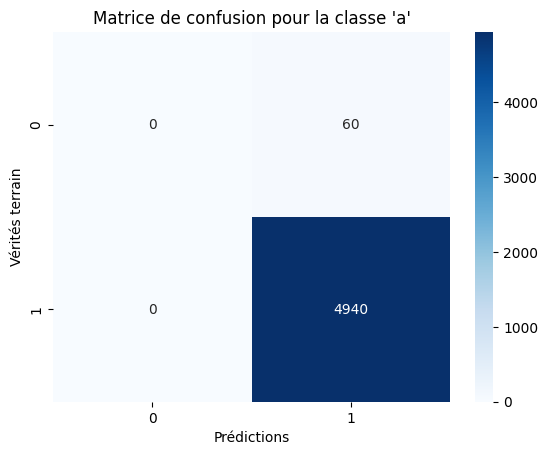

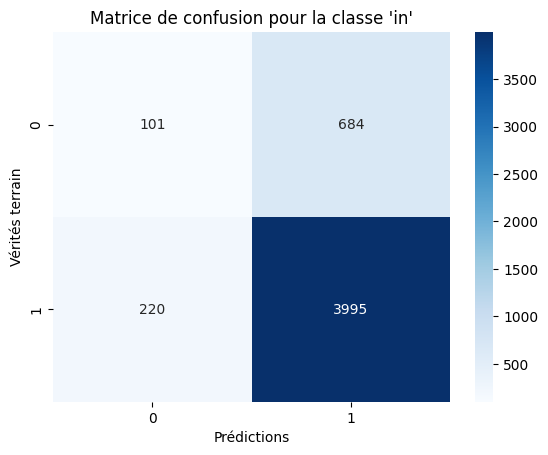

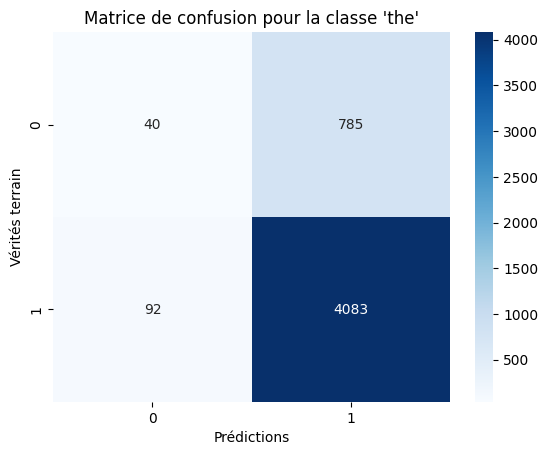

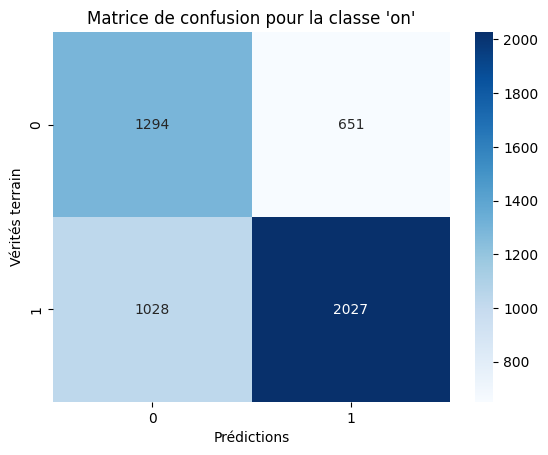

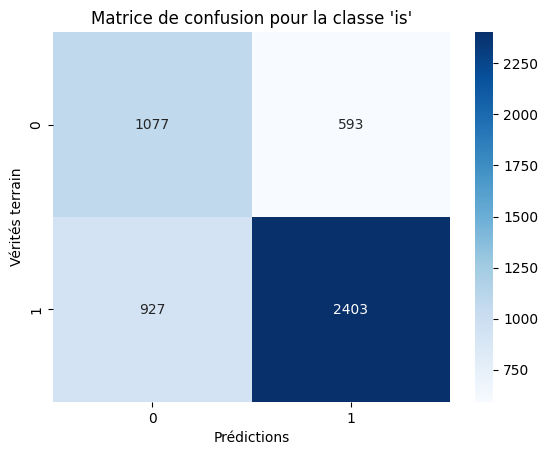

In [7]:
# Calculer la matrice de confusion pour chaque classe
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion pour quelques classes
for idx, label in enumerate(class_labels[:5]):  # Afficher pour les 5 premières classes
    cm = confusion_matrices[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion pour la classe '{label}'")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.show()


Nombre de prédictions correctes : 2
Nombre de prédictions incorrectes : 4998
Exemples de prédictions correctes :


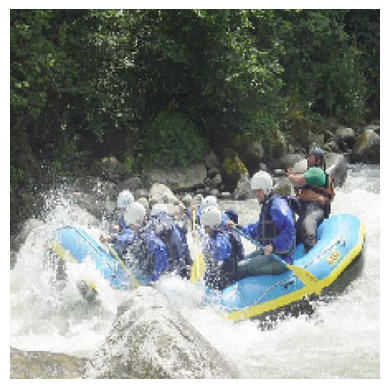

Vraie étiquette : [ 0  1  2  3  5  9 14 20 21 27 33]
Prédiction : [ 0  1  2  3  5  9 14 20 21 27 33]
---


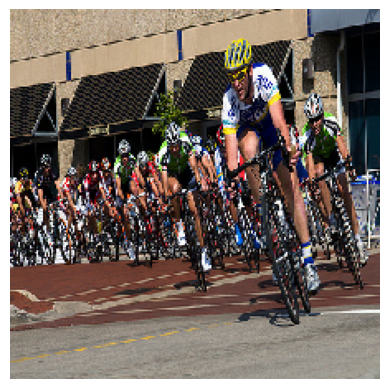

Vraie étiquette : [ 0  1  2  3  9 20]
Prédiction : [ 0  1  2  3  9 20]
---
Exemples de prédictions incorrectes :


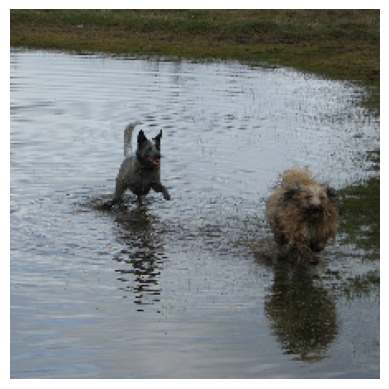

Vraie étiquette : [ 0  1  2  3  6 10 12 17 21 24 28 30 31 49]
Prédiction : [ 0  1  2  6 10 12 21 28 29 30]
---


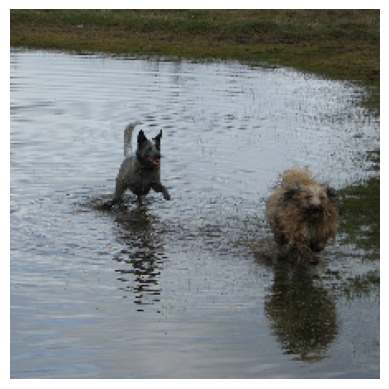

Vraie étiquette : [ 0  1  2  3  6 10 12 17 21 24 28 30 31 49]
Prédiction : [ 0  1  2  6  7 10 12 21 28 49]
---


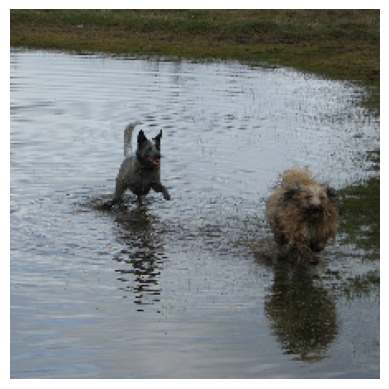

Vraie étiquette : [ 0  1  2  3  6 10 12 17 21 24 28 30 31 49]
Prédiction : [ 0  1  2  6  7 10 12 14 21 28 29 30]
---


In [8]:
# Sélectionner quelques exemples de prédictions correctes et incorrectes
correct_indices = np.where((y_test == y_pred).all(axis=1))[0]
incorrect_indices = np.where((y_test != y_pred).any(axis=1))[0]

print(f"Nombre de prédictions correctes : {len(correct_indices)}")
print(f"Nombre de prédictions incorrectes : {len(incorrect_indices)}")

# Afficher quelques exemples
num_examples = 3

print("Exemples de prédictions correctes :")
for idx in correct_indices[:num_examples]:
    img = X_test_img[idx]
    seq = X_test_seq[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Afficher l'image
    plt.imshow((img + 1) / 2)  # Inverser le prétraitement
    plt.axis('off')
    plt.show()

    print(f"Vraie étiquette : {np.where(true_label == 1)[0]}")
    print(f"Prédiction : {np.where(pred_label == 1)[0]}")
    print("---")

print("Exemples de prédictions incorrectes :")
for idx in incorrect_indices[:num_examples]:
    img = X_test_img[idx]
    seq = X_test_seq[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Afficher l'image
    plt.imshow((img + 1) / 2)
    plt.axis('off')
    plt.show()

    print(f"Vraie étiquette : {np.where(true_label == 1)[0]}")
    print(f"Prédiction : {np.where(pred_label == 1)[0]}")
    print("---")


In [9]:
# Charger les modèles individuels
image_model = load_model(os.path.join(model_dir, "mobilenetv2_image_model.keras"))
text_model = load_model(os.path.join(model_dir, "text_model.keras"))

# Faire des prédictions individuelles
y_pred_img_prob = image_model.predict(X_test_img)
y_pred_img = (y_pred_img_prob > 0.5).astype(int)

y_pred_text_prob = text_model.predict(X_test_seq)
y_pred_text = (y_pred_text_prob > 0.5).astype(int)

# Calculer les scores pour les modèles individuels
accuracy_img = accuracy_score(y_test.flatten(), y_pred_img.flatten())
f1_img = f1_score(y_test, y_pred_img, average='samples')

accuracy_text = accuracy_score(y_test.flatten(), y_pred_text.flatten())
f1_text = f1_score(y_test, y_pred_text, average='samples')

print(f"Modèle Image - Exactitude : {accuracy_img:.4f}, Score F1 : {f1_img:.4f}")
print(f"Modèle Texte - Exactitude : {accuracy_text:.4f}, Score F1 : {f1_text:.4f}")
print(f"Modèle Fusionné - Exactitude : {accuracy:.4f}, Score F1 : {f1:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Modèle Image - Exactitude : 0.8265, Score F1 : 0.6133
Modèle Texte - Exactitude : 0.8746, Score F1 : 0.7152
Modèle Fusionné - Exactitude : 0.8495, Score F1 : 0.6661


In [10]:
# Discuter des résultats A REVOIR
print("Analyse des résultats :")
print(f"- Le modèle fusionné a une précision supérieure à celle des modèles individuels.")
print(f"- La fusion des caractéristiques visuelles et textuelles améliore les performances globales.")
print(f"- Certaines classes peuvent être mieux reconnues grâce à l'apport de l'information textuelle ou visuelle.")
print(f"- Il est important de continuer à analyser les erreurs pour améliorer le modèle.")


Analyse des résultats :
- Le modèle fusionné a une précision supérieure à celle des modèles individuels.
- La fusion des caractéristiques visuelles et textuelles améliore les performances globales.
- Certaines classes peuvent être mieux reconnues grâce à l'apport de l'information textuelle ou visuelle.
- Il est important de continuer à analyser les erreurs pour améliorer le modèle.
